# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

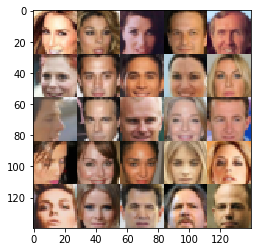

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\anaconda\envs\tensorflow35\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_imgs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'real_imgs')
    z_data = tf.placeholder(tf.float32, (None, z_dim), 'z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_imgs, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
stride = 5
padding = 2
img_filter_size = 64
h2_img_filter_size = img_filter_size*2
h3_img_filter_size = img_filter_size*4


def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # No alpha given so making a test        
        alpha = 0.2      
        
        # 1st Hidden layer
        h1 = tf.layers.conv2d(images, img_filter_size, stride, padding, 'same')
        h1 = tf.maximum(alpha * h1, h1) # Leaky ReLU
        
        # 2nd Hidden layer
        h2 = tf.layers.conv2d(h1, h2_img_filter_size, stride, padding, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True) # Batch normalizing
        h2 = tf.maximum(alpha * h2, h2) # Leaky ReLU
        
        # 3rd Hidden layer
        h3 = tf.layers.conv2d(h2, h3_img_filter_size, stride, padding, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True) # Batch normalizing
        h3 = tf.maximum(alpha * h3, h3) # Leaky ReLU
        
        flat = tf.reshape(h3, (-1, 4*4*h3_img_filter_size))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # Using the reverse process of the discriminator
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*h3_img_filter_size)
        h1 = tf.reshape(h1, (-1, 2, 2, h3_img_filter_size))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, h2_img_filter_size, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, img_filter_size, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate the Losses for it real, fake & generated models
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # The Discriminator Loss is the amount of it fake img loss + it real img loss
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Empty TF TrainableVariables
    t_vars = tf.trainable_variables()
    # Append var to D & G vars arraies if it starts with the "prefix" for on it name
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # discriminator optimization
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    
    # UPDATE OPS GraphKeys
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, img_width, img_height, img_channels = data_shape
    real_input_img, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input_img, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    n_images = 25        
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Training the Model
                steps += 1 # next batch
                batch_images *= 2.0 # the image is increasing by double for each layer
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim)) # uniform distribution
                
                # performing d_opt with the feed_dict knowledge
                _ = sess.run(d_opt, feed_dict={real_input_img: batch_images, z_input: z_sample, lr: learning_rate})
                # performing g_opt with the feed_dict knowledge
                _ = sess.run(g_opt, feed_dict={z_input: z_sample, lr: learning_rate})
                
                # Check if is it time to print the Loss or just keep going (skip the print)
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input_img: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                # Showing the generator output based on show_every step
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [14]:
z_dim = 100 # The dimension "size" of Z
beta1 = 0.5 # The exponential decay rate for the 1st moment in the optimizer
batch_size = 64 # The size of each amount of samples per processing
learning_rate = 0.002




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2


mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 0.0878... Generator Loss: 6.4049
Epoch 1/2... Discriminator Loss: 0.8140... Generator Loss: 1.2221
Epoch 1/2... Discriminator Loss: 0.9010... Generator Loss: 1.4534
Epoch 1/2... Discriminator Loss: 1.0379... Generator Loss: 0.6374
Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 7.6125
Epoch 1/2... Discriminator Loss: 0.6566... Generator Loss: 0.8507
Epoch 1/2... Discriminator Loss: 0.4227... Generator Loss: 1.3187
Epoch 1/2... Discriminator Loss: 0.2860... Generator Loss: 2.0077
Epoch 1/2... Discriminator Loss: 0.7548... Generator Loss: 7.5649
Epoch 1/2... Discriminator Loss: 0.6820... Generator Loss: 2.0793


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.4087... Generator Loss: 1.9856
Epoch 1/2... Discriminator Loss: 0.3479... Generator Loss: 2.3912
Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 5.9889
Epoch 1/2... Discriminator Loss: 0.3329... Generator Loss: 3.9124
Epoch 1/2... Discriminator Loss: 0.2270... Generator Loss: 3.0585
Epoch 1/2... Discriminator Loss: 1.5462... Generator Loss: 7.1903
Epoch 1/2... Discriminator Loss: 0.1177... Generator Loss: 3.0669
Epoch 1/2... Discriminator Loss: 0.2827... Generator Loss: 2.3052
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 7.0213
Epoch 1/2... Discriminator Loss: 0.2041... Generator Loss: 3.5133


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.8154... Generator Loss: 1.4333
Epoch 1/2... Discriminator Loss: 1.4952... Generator Loss: 0.7978
Epoch 1/2... Discriminator Loss: 0.6978... Generator Loss: 3.4511
Epoch 1/2... Discriminator Loss: 0.2147... Generator Loss: 2.3866
Epoch 1/2... Discriminator Loss: 2.0010... Generator Loss: 5.3818
Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 0.7696
Epoch 1/2... Discriminator Loss: 1.4153... Generator Loss: 3.0247
Epoch 1/2... Discriminator Loss: 1.5574... Generator Loss: 0.4268
Epoch 1/2... Discriminator Loss: 0.7372... Generator Loss: 1.4979
Epoch 1/2... Discriminator Loss: 0.3407... Generator Loss: 2.4898


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.2294... Generator Loss: 2.4727
Epoch 1/2... Discriminator Loss: 0.5400... Generator Loss: 1.8783
Epoch 1/2... Discriminator Loss: 0.5913... Generator Loss: 2.1473
Epoch 1/2... Discriminator Loss: 0.4838... Generator Loss: 1.9725
Epoch 1/2... Discriminator Loss: 0.3076... Generator Loss: 3.8957
Epoch 1/2... Discriminator Loss: 1.8004... Generator Loss: 0.5261
Epoch 1/2... Discriminator Loss: 0.7631... Generator Loss: 3.9028
Epoch 1/2... Discriminator Loss: 1.0205... Generator Loss: 1.0967
Epoch 1/2... Discriminator Loss: 0.4534... Generator Loss: 3.2543
Epoch 1/2... Discriminator Loss: 0.6494... Generator Loss: 2.5538


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.8420... Generator Loss: 1.1566
Epoch 1/2... Discriminator Loss: 0.5840... Generator Loss: 1.6012
Epoch 1/2... Discriminator Loss: 0.4351... Generator Loss: 3.0067
Epoch 1/2... Discriminator Loss: 0.8104... Generator Loss: 2.9041
Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 2.9508
Epoch 1/2... Discriminator Loss: 0.5187... Generator Loss: 1.6452
Epoch 1/2... Discriminator Loss: 0.4484... Generator Loss: 2.9797
Epoch 1/2... Discriminator Loss: 0.5578... Generator Loss: 1.3598
Epoch 1/2... Discriminator Loss: 0.6338... Generator Loss: 1.6330
Epoch 1/2... Discriminator Loss: 0.6019... Generator Loss: 1.6089


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 3.5560
Epoch 1/2... Discriminator Loss: 0.7567... Generator Loss: 1.7517
Epoch 1/2... Discriminator Loss: 0.8223... Generator Loss: 2.5593
Epoch 1/2... Discriminator Loss: 0.6382... Generator Loss: 1.1915
Epoch 1/2... Discriminator Loss: 0.9548... Generator Loss: 1.9197
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 0.8513
Epoch 1/2... Discriminator Loss: 1.4026... Generator Loss: 0.6218
Epoch 1/2... Discriminator Loss: 0.4872... Generator Loss: 2.2225
Epoch 1/2... Discriminator Loss: 0.5256... Generator Loss: 2.2187
Epoch 1/2... Discriminator Loss: 0.6026... Generator Loss: 2.8051


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 2.3075
Epoch 1/2... Discriminator Loss: 0.7546... Generator Loss: 1.1487
Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 0.8590
Epoch 1/2... Discriminator Loss: 0.7383... Generator Loss: 1.6263
Epoch 1/2... Discriminator Loss: 0.6776... Generator Loss: 1.3622
Epoch 1/2... Discriminator Loss: 0.8299... Generator Loss: 1.0258
Epoch 1/2... Discriminator Loss: 0.8462... Generator Loss: 1.8495
Epoch 1/2... Discriminator Loss: 0.8211... Generator Loss: 0.9459
Epoch 1/2... Discriminator Loss: 0.6899... Generator Loss: 1.4551


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.8592... Generator Loss: 1.3743
Epoch 1/2... Discriminator Loss: 0.8095... Generator Loss: 1.1433
Epoch 1/2... Discriminator Loss: 0.6694... Generator Loss: 1.3981
Epoch 1/2... Discriminator Loss: 0.9349... Generator Loss: 2.2590
Epoch 1/2... Discriminator Loss: 0.6316... Generator Loss: 1.5789
Epoch 1/2... Discriminator Loss: 0.6009... Generator Loss: 1.5201
Epoch 1/2... Discriminator Loss: 1.4976... Generator Loss: 3.9413
Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 0.6276
Epoch 1/2... Discriminator Loss: 0.8576... Generator Loss: 1.4837
Epoch 1/2... Discriminator Loss: 0.8988... Generator Loss: 0.9570


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.9002... Generator Loss: 1.9279
Epoch 1/2... Discriminator Loss: 0.8510... Generator Loss: 1.1800
Epoch 1/2... Discriminator Loss: 0.7461... Generator Loss: 1.2205
Epoch 1/2... Discriminator Loss: 0.7205... Generator Loss: 1.9045
Epoch 1/2... Discriminator Loss: 0.8104... Generator Loss: 1.3649
Epoch 1/2... Discriminator Loss: 2.0668... Generator Loss: 0.4173
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 1.6760
Epoch 1/2... Discriminator Loss: 0.6980... Generator Loss: 1.0990
Epoch 1/2... Discriminator Loss: 0.8428... Generator Loss: 1.1100
Epoch 1/2... Discriminator Loss: 0.6168... Generator Loss: 1.6976


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 1.3726
Epoch 1/2... Discriminator Loss: 0.8000... Generator Loss: 1.0593
Epoch 1/2... Discriminator Loss: 1.1139... Generator Loss: 1.9102
Epoch 2/2... Discriminator Loss: 1.0598... Generator Loss: 0.6805
Epoch 2/2... Discriminator Loss: 0.9375... Generator Loss: 0.9797
Epoch 2/2... Discriminator Loss: 0.9582... Generator Loss: 0.8774
Epoch 2/2... Discriminator Loss: 0.9614... Generator Loss: 1.4882
Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 0.5537
Epoch 2/2... Discriminator Loss: 0.9594... Generator Loss: 1.4356
Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 0.9771


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.8619... Generator Loss: 1.2122
Epoch 2/2... Discriminator Loss: 0.7970... Generator Loss: 1.7451
Epoch 2/2... Discriminator Loss: 1.1037... Generator Loss: 0.5781
Epoch 2/2... Discriminator Loss: 1.3343... Generator Loss: 0.4878
Epoch 2/2... Discriminator Loss: 0.7843... Generator Loss: 1.7188
Epoch 2/2... Discriminator Loss: 0.8445... Generator Loss: 1.1709
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.4917
Epoch 2/2... Discriminator Loss: 0.9177... Generator Loss: 0.9260
Epoch 2/2... Discriminator Loss: 0.8380... Generator Loss: 1.6159
Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.4114


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.9365... Generator Loss: 0.9060
Epoch 2/2... Discriminator Loss: 0.7178... Generator Loss: 1.2817
Epoch 2/2... Discriminator Loss: 0.8220... Generator Loss: 0.9024
Epoch 2/2... Discriminator Loss: 0.7632... Generator Loss: 1.0008
Epoch 2/2... Discriminator Loss: 0.8517... Generator Loss: 0.8919
Epoch 2/2... Discriminator Loss: 1.0458... Generator Loss: 0.9854
Epoch 2/2... Discriminator Loss: 0.7524... Generator Loss: 1.0311
Epoch 2/2... Discriminator Loss: 1.3389... Generator Loss: 0.4477
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 1.2043
Epoch 2/2... Discriminator Loss: 0.5779... Generator Loss: 1.5825


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.6515... Generator Loss: 2.5954
Epoch 2/2... Discriminator Loss: 0.9390... Generator Loss: 1.9135
Epoch 2/2... Discriminator Loss: 0.8633... Generator Loss: 1.0343
Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 0.6121
Epoch 2/2... Discriminator Loss: 1.0978... Generator Loss: 2.2571
Epoch 2/2... Discriminator Loss: 0.9354... Generator Loss: 0.7581
Epoch 2/2... Discriminator Loss: 0.9538... Generator Loss: 0.7458
Epoch 2/2... Discriminator Loss: 1.1162... Generator Loss: 0.6849
Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 1.3440
Epoch 2/2... Discriminator Loss: 1.3150... Generator Loss: 2.5719


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 1.1888... Generator Loss: 0.5832
Epoch 2/2... Discriminator Loss: 1.3189... Generator Loss: 0.4681
Epoch 2/2... Discriminator Loss: 0.7344... Generator Loss: 2.8116
Epoch 2/2... Discriminator Loss: 0.7582... Generator Loss: 1.4002
Epoch 2/2... Discriminator Loss: 1.2632... Generator Loss: 0.5511
Epoch 2/2... Discriminator Loss: 0.8839... Generator Loss: 0.7819
Epoch 2/2... Discriminator Loss: 4.1812... Generator Loss: 5.6805
Epoch 2/2... Discriminator Loss: 0.9225... Generator Loss: 0.8735
Epoch 2/2... Discriminator Loss: 0.7582... Generator Loss: 1.3553
Epoch 2/2... Discriminator Loss: 0.9742... Generator Loss: 1.7083


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.9876... Generator Loss: 1.6263
Epoch 2/2... Discriminator Loss: 1.5367... Generator Loss: 2.5411
Epoch 2/2... Discriminator Loss: 1.5508... Generator Loss: 0.3440
Epoch 2/2... Discriminator Loss: 0.5765... Generator Loss: 1.4743
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 0.7016
Epoch 2/2... Discriminator Loss: 0.5756... Generator Loss: 1.4107
Epoch 2/2... Discriminator Loss: 0.6167... Generator Loss: 2.7777
Epoch 2/2... Discriminator Loss: 0.9740... Generator Loss: 1.4134
Epoch 2/2... Discriminator Loss: 0.5547... Generator Loss: 1.3186
Epoch 2/2... Discriminator Loss: 1.0417... Generator Loss: 0.7029


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.8512... Generator Loss: 0.9155
Epoch 2/2... Discriminator Loss: 1.0253... Generator Loss: 0.6216
Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 1.5247
Epoch 2/2... Discriminator Loss: 0.7536... Generator Loss: 1.0321
Epoch 2/2... Discriminator Loss: 0.5480... Generator Loss: 1.5126
Epoch 2/2... Discriminator Loss: 1.0581... Generator Loss: 0.6394
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.6554
Epoch 2/2... Discriminator Loss: 0.6418... Generator Loss: 1.4931
Epoch 2/2... Discriminator Loss: 1.5287... Generator Loss: 0.4017
Epoch 2/2... Discriminator Loss: 1.1726... Generator Loss: 0.6790


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 1.1961... Generator Loss: 0.5601
Epoch 2/2... Discriminator Loss: 0.6264... Generator Loss: 1.5202
Epoch 2/2... Discriminator Loss: 2.2659... Generator Loss: 0.2142
Epoch 2/2... Discriminator Loss: 2.0370... Generator Loss: 0.2691
Epoch 2/2... Discriminator Loss: 1.0805... Generator Loss: 1.3773
Epoch 2/2... Discriminator Loss: 0.7992... Generator Loss: 1.0141
Epoch 2/2... Discriminator Loss: 1.0252... Generator Loss: 0.6793
Epoch 2/2... Discriminator Loss: 0.8838... Generator Loss: 3.3364
Epoch 2/2... Discriminator Loss: 1.1569... Generator Loss: 0.5924
Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.3804


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 2.2077... Generator Loss: 0.2449
Epoch 2/2... Discriminator Loss: 1.4084... Generator Loss: 0.4648
Epoch 2/2... Discriminator Loss: 1.6599... Generator Loss: 0.3569
Epoch 2/2... Discriminator Loss: 0.8015... Generator Loss: 1.2287
Epoch 2/2... Discriminator Loss: 0.6837... Generator Loss: 1.4772
Epoch 2/2... Discriminator Loss: 0.6988... Generator Loss: 1.7289
Epoch 2/2... Discriminator Loss: 0.7287... Generator Loss: 1.5039
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 0.8264
Epoch 2/2... Discriminator Loss: 0.4878... Generator Loss: 1.3537
Epoch 2/2... Discriminator Loss: 0.8912... Generator Loss: 0.9999


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 1.0861... Generator Loss: 0.8647
Epoch 2/2... Discriminator Loss: 1.4254... Generator Loss: 0.4662
Epoch 2/2... Discriminator Loss: 0.7079... Generator Loss: 1.2455
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 0.6100
Epoch 2/2... Discriminator Loss: 1.4714... Generator Loss: 0.4359
Epoch 2/2... Discriminator Loss: 0.8124... Generator Loss: 1.1852
Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 1.3574


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.5409... Generator Loss: 6.6437
Epoch 1/2... Discriminator Loss: 1.3252... Generator Loss: 7.3785
Epoch 1/2... Discriminator Loss: 0.5452... Generator Loss: 1.6278
Epoch 1/2... Discriminator Loss: 0.2217... Generator Loss: 2.9998
Epoch 1/2... Discriminator Loss: 0.8415... Generator Loss: 4.6753
Epoch 1/2... Discriminator Loss: 0.9318... Generator Loss: 0.6426
Epoch 1/2... Discriminator Loss: 0.2589... Generator Loss: 3.0743
Epoch 1/2... Discriminator Loss: 1.7129... Generator Loss: 0.4234
Epoch 1/2... Discriminator Loss: 1.5826... Generator Loss: 4.9026
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.7303


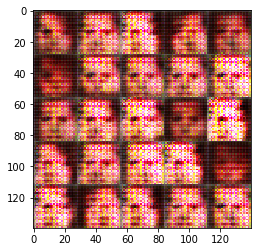

Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 0.5862
Epoch 1/2... Discriminator Loss: 0.6343... Generator Loss: 1.0039
Epoch 1/2... Discriminator Loss: 0.2072... Generator Loss: 2.1789
Epoch 1/2... Discriminator Loss: 3.1371... Generator Loss: 0.4011
Epoch 1/2... Discriminator Loss: 0.8817... Generator Loss: 2.8640
Epoch 1/2... Discriminator Loss: 1.0612... Generator Loss: 0.7206
Epoch 1/2... Discriminator Loss: 0.5329... Generator Loss: 1.3586
Epoch 1/2... Discriminator Loss: 0.3840... Generator Loss: 2.2172
Epoch 1/2... Discriminator Loss: 1.7202... Generator Loss: 1.3848
Epoch 1/2... Discriminator Loss: 0.6483... Generator Loss: 1.3996


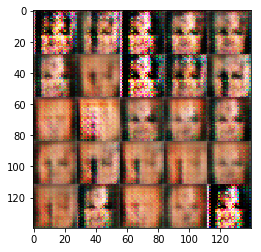

Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 1.1062
Epoch 1/2... Discriminator Loss: 0.8372... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 0.4149... Generator Loss: 1.4623
Epoch 1/2... Discriminator Loss: 0.3662... Generator Loss: 3.1293
Epoch 1/2... Discriminator Loss: 0.7620... Generator Loss: 2.2448
Epoch 1/2... Discriminator Loss: 3.0357... Generator Loss: 5.4549
Epoch 1/2... Discriminator Loss: 0.5821... Generator Loss: 1.2989
Epoch 1/2... Discriminator Loss: 1.1218... Generator Loss: 0.9870
Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 1.7192
Epoch 1/2... Discriminator Loss: 0.9818... Generator Loss: 1.1606


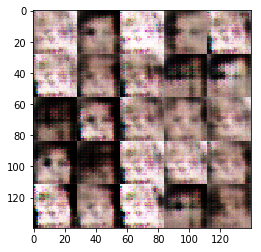

Epoch 1/2... Discriminator Loss: 1.0629... Generator Loss: 3.1470
Epoch 1/2... Discriminator Loss: 3.8036... Generator Loss: 5.1409
Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 0.7115
Epoch 1/2... Discriminator Loss: 0.9516... Generator Loss: 1.2629
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 0.6257
Epoch 1/2... Discriminator Loss: 1.0338... Generator Loss: 0.8374
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 0.9486
Epoch 1/2... Discriminator Loss: 1.0799... Generator Loss: 0.6960
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 0.6873
Epoch 1/2... Discriminator Loss: 1.2760... Generator Loss: 0.5042


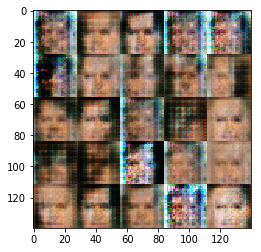

Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 1.9849
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 0.5873
Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 2.4069
Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 0.5632
Epoch 1/2... Discriminator Loss: 1.0477... Generator Loss: 0.6615
Epoch 1/2... Discriminator Loss: 0.7669... Generator Loss: 1.0555
Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 0.6652
Epoch 1/2... Discriminator Loss: 1.5680... Generator Loss: 0.3431
Epoch 1/2... Discriminator Loss: 0.6636... Generator Loss: 1.3595
Epoch 1/2... Discriminator Loss: 2.5038... Generator Loss: 3.2951


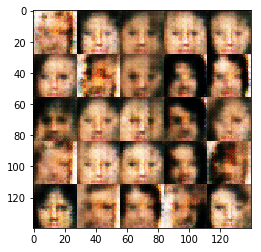

Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.5137
Epoch 1/2... Discriminator Loss: 1.5656... Generator Loss: 0.3781
Epoch 1/2... Discriminator Loss: 0.6111... Generator Loss: 1.3024
Epoch 1/2... Discriminator Loss: 0.6167... Generator Loss: 1.2104
Epoch 1/2... Discriminator Loss: 1.4702... Generator Loss: 0.5422
Epoch 1/2... Discriminator Loss: 0.9288... Generator Loss: 1.1823
Epoch 1/2... Discriminator Loss: 0.8821... Generator Loss: 1.7834
Epoch 1/2... Discriminator Loss: 1.0103... Generator Loss: 2.5550
Epoch 1/2... Discriminator Loss: 1.2324... Generator Loss: 2.7544
Epoch 1/2... Discriminator Loss: 1.4156... Generator Loss: 0.4468


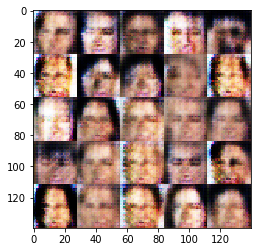

Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 0.6631
Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 0.9225
Epoch 1/2... Discriminator Loss: 0.7469... Generator Loss: 2.0840
Epoch 1/2... Discriminator Loss: 1.9063... Generator Loss: 3.5590
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 0.9781
Epoch 1/2... Discriminator Loss: 0.8639... Generator Loss: 1.1782
Epoch 1/2... Discriminator Loss: 0.8045... Generator Loss: 1.2929
Epoch 1/2... Discriminator Loss: 0.8037... Generator Loss: 1.2021
Epoch 1/2... Discriminator Loss: 1.8171... Generator Loss: 0.2723
Epoch 1/2... Discriminator Loss: 1.5314... Generator Loss: 0.4016


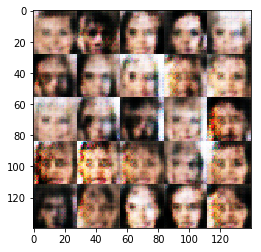

Epoch 1/2... Discriminator Loss: 1.6685... Generator Loss: 2.6423
Epoch 1/2... Discriminator Loss: 1.5163... Generator Loss: 0.4920
Epoch 1/2... Discriminator Loss: 1.5247... Generator Loss: 3.4482
Epoch 1/2... Discriminator Loss: 0.6517... Generator Loss: 1.2485
Epoch 1/2... Discriminator Loss: 0.7217... Generator Loss: 1.3765
Epoch 1/2... Discriminator Loss: 0.8033... Generator Loss: 0.9621
Epoch 1/2... Discriminator Loss: 2.2713... Generator Loss: 0.1535
Epoch 1/2... Discriminator Loss: 0.6873... Generator Loss: 1.5382
Epoch 1/2... Discriminator Loss: 1.0817... Generator Loss: 0.7517
Epoch 1/2... Discriminator Loss: 1.1375... Generator Loss: 0.6480


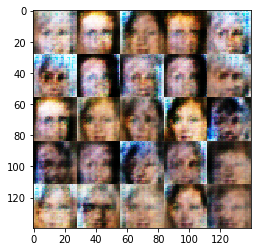

Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 1.2566
Epoch 1/2... Discriminator Loss: 0.9945... Generator Loss: 0.9732
Epoch 1/2... Discriminator Loss: 1.2296... Generator Loss: 0.5966
Epoch 1/2... Discriminator Loss: 1.2268... Generator Loss: 0.7802
Epoch 1/2... Discriminator Loss: 1.1435... Generator Loss: 0.5699
Epoch 1/2... Discriminator Loss: 1.0861... Generator Loss: 0.6385
Epoch 1/2... Discriminator Loss: 0.7214... Generator Loss: 1.4172
Epoch 1/2... Discriminator Loss: 0.8062... Generator Loss: 1.4388
Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 0.5128
Epoch 1/2... Discriminator Loss: 0.7705... Generator Loss: 1.1615


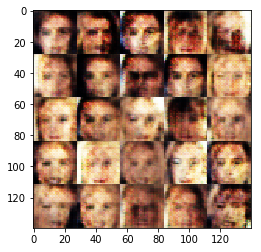

Epoch 1/2... Discriminator Loss: 1.1346... Generator Loss: 0.8681
Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 0.7579
Epoch 1/2... Discriminator Loss: 0.9095... Generator Loss: 0.9349
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 1.5497
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 1.9258
Epoch 1/2... Discriminator Loss: 1.3438... Generator Loss: 0.4900
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 0.4605
Epoch 1/2... Discriminator Loss: 0.8145... Generator Loss: 1.1744
Epoch 1/2... Discriminator Loss: 1.0510... Generator Loss: 0.6364
Epoch 1/2... Discriminator Loss: 1.1008... Generator Loss: 0.6483


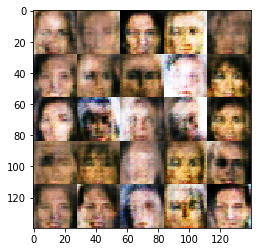

Epoch 1/2... Discriminator Loss: 1.1222... Generator Loss: 0.6461
Epoch 1/2... Discriminator Loss: 0.8812... Generator Loss: 1.0910
Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 0.6872
Epoch 1/2... Discriminator Loss: 0.8022... Generator Loss: 0.9040
Epoch 1/2... Discriminator Loss: 1.5136... Generator Loss: 3.0799
Epoch 1/2... Discriminator Loss: 1.1973... Generator Loss: 1.7603
Epoch 1/2... Discriminator Loss: 0.8717... Generator Loss: 1.1959
Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 0.7884
Epoch 1/2... Discriminator Loss: 1.0632... Generator Loss: 0.6442
Epoch 1/2... Discriminator Loss: 1.0560... Generator Loss: 0.7619


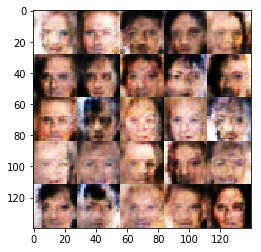

Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 0.5192
Epoch 1/2... Discriminator Loss: 0.8619... Generator Loss: 1.6845
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 1.2291
Epoch 1/2... Discriminator Loss: 0.6723... Generator Loss: 1.5050
Epoch 1/2... Discriminator Loss: 0.8884... Generator Loss: 1.9251
Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 0.7061
Epoch 1/2... Discriminator Loss: 1.5036... Generator Loss: 0.3993
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 1.0063
Epoch 1/2... Discriminator Loss: 0.9719... Generator Loss: 0.7070
Epoch 1/2... Discriminator Loss: 0.6271... Generator Loss: 2.0092


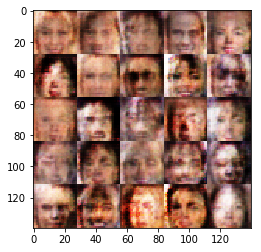

Epoch 1/2... Discriminator Loss: 0.7980... Generator Loss: 1.3880
Epoch 1/2... Discriminator Loss: 1.2002... Generator Loss: 0.6571
Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.4664
Epoch 1/2... Discriminator Loss: 2.2893... Generator Loss: 0.1569
Epoch 1/2... Discriminator Loss: 0.8956... Generator Loss: 1.0097
Epoch 1/2... Discriminator Loss: 1.4204... Generator Loss: 0.4211
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 0.6538
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.4252
Epoch 1/2... Discriminator Loss: 1.5436... Generator Loss: 0.3987
Epoch 1/2... Discriminator Loss: 0.8884... Generator Loss: 0.8997


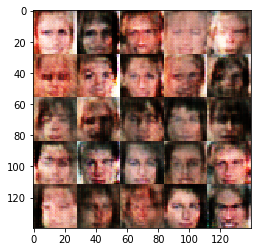

Epoch 1/2... Discriminator Loss: 1.1499... Generator Loss: 1.2081
Epoch 1/2... Discriminator Loss: 1.1716... Generator Loss: 2.0261
Epoch 1/2... Discriminator Loss: 0.8966... Generator Loss: 1.9576
Epoch 1/2... Discriminator Loss: 0.6668... Generator Loss: 1.3947
Epoch 1/2... Discriminator Loss: 0.8538... Generator Loss: 1.4476
Epoch 1/2... Discriminator Loss: 0.8491... Generator Loss: 1.4375
Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.4637
Epoch 1/2... Discriminator Loss: 0.6554... Generator Loss: 1.3952
Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 0.8002... Generator Loss: 1.5682


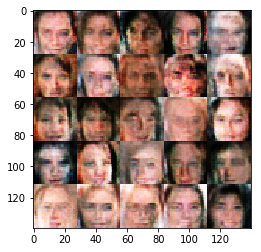

Epoch 1/2... Discriminator Loss: 0.7952... Generator Loss: 1.1532
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 1.8066
Epoch 1/2... Discriminator Loss: 0.9169... Generator Loss: 0.8563
Epoch 1/2... Discriminator Loss: 0.7829... Generator Loss: 1.7234
Epoch 1/2... Discriminator Loss: 0.9406... Generator Loss: 1.3436
Epoch 1/2... Discriminator Loss: 0.8714... Generator Loss: 0.9492
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 2.2077
Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 0.5053
Epoch 1/2... Discriminator Loss: 0.9774... Generator Loss: 0.9464
Epoch 1/2... Discriminator Loss: 0.7493... Generator Loss: 0.8930


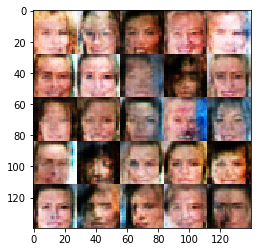

Epoch 1/2... Discriminator Loss: 0.8505... Generator Loss: 1.2217
Epoch 1/2... Discriminator Loss: 0.9118... Generator Loss: 0.8704
Epoch 1/2... Discriminator Loss: 1.1546... Generator Loss: 2.4503
Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 1.8560
Epoch 1/2... Discriminator Loss: 0.8999... Generator Loss: 0.9959
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 1.0551
Epoch 1/2... Discriminator Loss: 1.5778... Generator Loss: 0.3187
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 0.5236
Epoch 1/2... Discriminator Loss: 1.5660... Generator Loss: 0.3183
Epoch 1/2... Discriminator Loss: 0.9461... Generator Loss: 1.5847


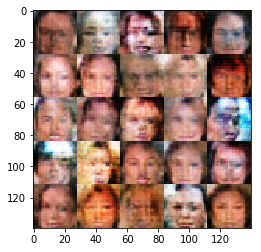

Epoch 1/2... Discriminator Loss: 0.7916... Generator Loss: 1.1905
Epoch 1/2... Discriminator Loss: 1.2304... Generator Loss: 0.5533
Epoch 1/2... Discriminator Loss: 1.5422... Generator Loss: 0.4001
Epoch 1/2... Discriminator Loss: 1.5503... Generator Loss: 0.3282
Epoch 1/2... Discriminator Loss: 1.0590... Generator Loss: 0.6826
Epoch 1/2... Discriminator Loss: 0.9327... Generator Loss: 1.2819
Epoch 1/2... Discriminator Loss: 1.0095... Generator Loss: 1.0497
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 1.9062
Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 2.7099
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 0.6092


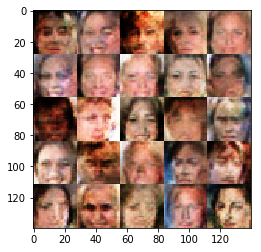

Epoch 1/2... Discriminator Loss: 0.7243... Generator Loss: 1.6017
Epoch 1/2... Discriminator Loss: 0.7642... Generator Loss: 1.1996
Epoch 1/2... Discriminator Loss: 0.8371... Generator Loss: 1.0958
Epoch 1/2... Discriminator Loss: 0.8574... Generator Loss: 1.2256
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 2.3894
Epoch 1/2... Discriminator Loss: 0.9286... Generator Loss: 0.8672
Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 0.9861
Epoch 1/2... Discriminator Loss: 0.8509... Generator Loss: 1.1330
Epoch 1/2... Discriminator Loss: 1.7411... Generator Loss: 0.3181
Epoch 1/2... Discriminator Loss: 0.9792... Generator Loss: 1.3514


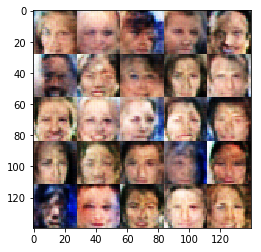

Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 2.3484
Epoch 1/2... Discriminator Loss: 1.8632... Generator Loss: 0.3169
Epoch 1/2... Discriminator Loss: 1.0162... Generator Loss: 1.0207
Epoch 1/2... Discriminator Loss: 1.4533... Generator Loss: 2.8359
Epoch 1/2... Discriminator Loss: 1.2684... Generator Loss: 1.0188
Epoch 1/2... Discriminator Loss: 0.8176... Generator Loss: 1.5109
Epoch 1/2... Discriminator Loss: 1.2550... Generator Loss: 1.2602
Epoch 1/2... Discriminator Loss: 1.5420... Generator Loss: 0.4192
Epoch 1/2... Discriminator Loss: 1.2948... Generator Loss: 2.0722
Epoch 1/2... Discriminator Loss: 0.7777... Generator Loss: 1.6294


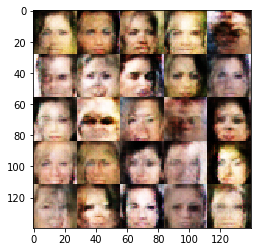

Epoch 1/2... Discriminator Loss: 0.8492... Generator Loss: 1.3100
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 1.1620
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 0.7434
Epoch 1/2... Discriminator Loss: 0.9706... Generator Loss: 1.7476
Epoch 1/2... Discriminator Loss: 1.7533... Generator Loss: 0.2898
Epoch 1/2... Discriminator Loss: 0.9377... Generator Loss: 0.9859
Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 0.7925
Epoch 1/2... Discriminator Loss: 0.7932... Generator Loss: 1.0267
Epoch 1/2... Discriminator Loss: 1.0437... Generator Loss: 0.7182
Epoch 1/2... Discriminator Loss: 0.8554... Generator Loss: 1.2175


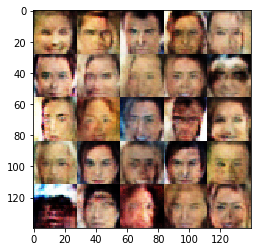

Epoch 1/2... Discriminator Loss: 1.2471... Generator Loss: 0.4967
Epoch 1/2... Discriminator Loss: 0.9413... Generator Loss: 0.8803
Epoch 1/2... Discriminator Loss: 0.9638... Generator Loss: 1.8242
Epoch 1/2... Discriminator Loss: 0.8446... Generator Loss: 1.2666
Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 0.7300
Epoch 1/2... Discriminator Loss: 0.8217... Generator Loss: 1.1300
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 0.6142
Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 2.0666
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 0.6143
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 1.5707


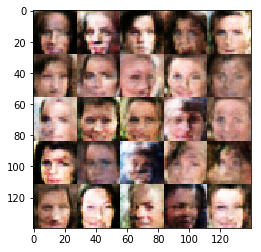

Epoch 1/2... Discriminator Loss: 0.8501... Generator Loss: 1.0076
Epoch 1/2... Discriminator Loss: 0.8096... Generator Loss: 0.9971
Epoch 1/2... Discriminator Loss: 0.8551... Generator Loss: 1.1541
Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 0.6856
Epoch 1/2... Discriminator Loss: 0.9083... Generator Loss: 0.8864
Epoch 1/2... Discriminator Loss: 1.0311... Generator Loss: 0.9233
Epoch 1/2... Discriminator Loss: 0.8980... Generator Loss: 0.9380
Epoch 1/2... Discriminator Loss: 0.9603... Generator Loss: 0.7475
Epoch 1/2... Discriminator Loss: 1.2356... Generator Loss: 0.4953
Epoch 1/2... Discriminator Loss: 0.7602... Generator Loss: 1.2115


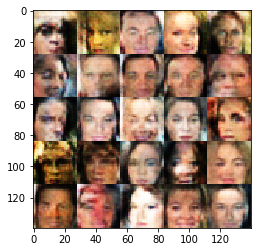

Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 1.3356
Epoch 1/2... Discriminator Loss: 0.9705... Generator Loss: 0.7194
Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 1.1599
Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 1.6423
Epoch 1/2... Discriminator Loss: 1.1266... Generator Loss: 0.6663
Epoch 1/2... Discriminator Loss: 1.0772... Generator Loss: 0.7562
Epoch 1/2... Discriminator Loss: 1.2381... Generator Loss: 0.5287
Epoch 1/2... Discriminator Loss: 0.8748... Generator Loss: 1.0915
Epoch 1/2... Discriminator Loss: 0.8819... Generator Loss: 1.8235
Epoch 1/2... Discriminator Loss: 0.7216... Generator Loss: 2.0442


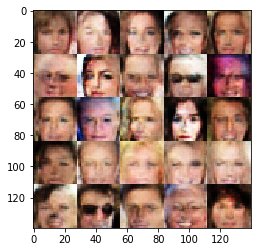

Epoch 1/2... Discriminator Loss: 0.9513... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 0.8870... Generator Loss: 1.3033
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.0135... Generator Loss: 1.1600
Epoch 1/2... Discriminator Loss: 1.5745... Generator Loss: 2.6511
Epoch 1/2... Discriminator Loss: 0.8999... Generator Loss: 1.5119
Epoch 1/2... Discriminator Loss: 0.9640... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 0.8164... Generator Loss: 1.1688
Epoch 1/2... Discriminator Loss: 0.8226... Generator Loss: 1.0588
Epoch 1/2... Discriminator Loss: 0.9760... Generator Loss: 0.7054


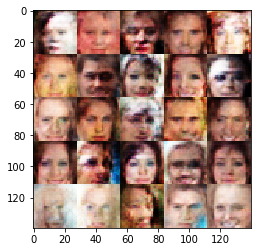

Epoch 1/2... Discriminator Loss: 1.0172... Generator Loss: 1.6686
Epoch 1/2... Discriminator Loss: 1.7474... Generator Loss: 0.3059
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 1.2824
Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 1.5682
Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 0.7396
Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 0.4448
Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 0.8425
Epoch 1/2... Discriminator Loss: 0.8899... Generator Loss: 1.4715
Epoch 1/2... Discriminator Loss: 0.8199... Generator Loss: 1.2880
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.3888


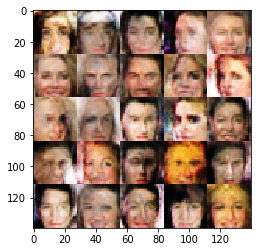

Epoch 1/2... Discriminator Loss: 1.0560... Generator Loss: 1.0421
Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 0.5711
Epoch 1/2... Discriminator Loss: 1.2141... Generator Loss: 0.5350
Epoch 1/2... Discriminator Loss: 0.8297... Generator Loss: 1.0629
Epoch 1/2... Discriminator Loss: 1.6399... Generator Loss: 0.3529
Epoch 1/2... Discriminator Loss: 0.9308... Generator Loss: 1.3568
Epoch 1/2... Discriminator Loss: 1.8791... Generator Loss: 2.8605
Epoch 1/2... Discriminator Loss: 0.8080... Generator Loss: 1.6674
Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 1.4589
Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 0.9473


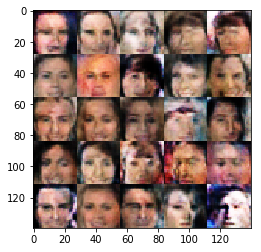

Epoch 1/2... Discriminator Loss: 0.7966... Generator Loss: 1.3206
Epoch 1/2... Discriminator Loss: 0.9160... Generator Loss: 1.5095
Epoch 1/2... Discriminator Loss: 1.3182... Generator Loss: 0.4632
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 0.7641
Epoch 1/2... Discriminator Loss: 0.9248... Generator Loss: 0.7212
Epoch 1/2... Discriminator Loss: 1.2051... Generator Loss: 0.8354
Epoch 1/2... Discriminator Loss: 1.1722... Generator Loss: 0.5584
Epoch 1/2... Discriminator Loss: 0.8272... Generator Loss: 0.9735
Epoch 1/2... Discriminator Loss: 0.8676... Generator Loss: 1.3329
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 0.9141


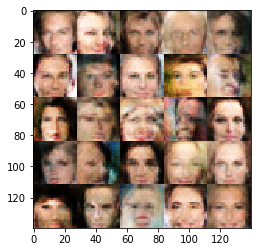

Epoch 1/2... Discriminator Loss: 1.2780... Generator Loss: 1.0564
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.5986
Epoch 1/2... Discriminator Loss: 1.1394... Generator Loss: 0.6412
Epoch 1/2... Discriminator Loss: 0.8403... Generator Loss: 1.2667
Epoch 1/2... Discriminator Loss: 1.0662... Generator Loss: 0.8106
Epoch 1/2... Discriminator Loss: 0.8338... Generator Loss: 0.9542
Epoch 1/2... Discriminator Loss: 0.9038... Generator Loss: 1.2786
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 0.8791
Epoch 1/2... Discriminator Loss: 1.3137... Generator Loss: 0.4661
Epoch 1/2... Discriminator Loss: 0.8733... Generator Loss: 1.2247


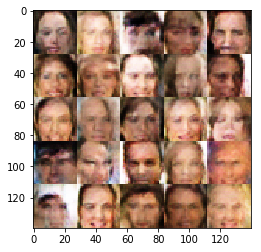

Epoch 1/2... Discriminator Loss: 0.9738... Generator Loss: 0.8204
Epoch 1/2... Discriminator Loss: 1.1917... Generator Loss: 0.5253
Epoch 1/2... Discriminator Loss: 0.8532... Generator Loss: 1.2266
Epoch 1/2... Discriminator Loss: 1.1540... Generator Loss: 1.5037
Epoch 1/2... Discriminator Loss: 1.1713... Generator Loss: 2.1004
Epoch 1/2... Discriminator Loss: 1.2865... Generator Loss: 0.4750
Epoch 1/2... Discriminator Loss: 1.1190... Generator Loss: 1.3883
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 0.7113
Epoch 1/2... Discriminator Loss: 0.8888... Generator Loss: 1.7378
Epoch 1/2... Discriminator Loss: 1.1022... Generator Loss: 0.6319


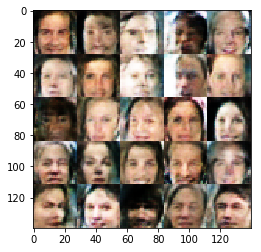

Epoch 1/2... Discriminator Loss: 1.7436... Generator Loss: 2.3015
Epoch 1/2... Discriminator Loss: 1.1219... Generator Loss: 1.6702
Epoch 1/2... Discriminator Loss: 0.9333... Generator Loss: 1.4144
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 1.7749
Epoch 1/2... Discriminator Loss: 1.1050... Generator Loss: 1.0279
Epoch 1/2... Discriminator Loss: 0.8351... Generator Loss: 0.9664
Epoch 1/2... Discriminator Loss: 0.9270... Generator Loss: 0.8445
Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 0.7900
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.5905
Epoch 1/2... Discriminator Loss: 1.1803... Generator Loss: 0.5335


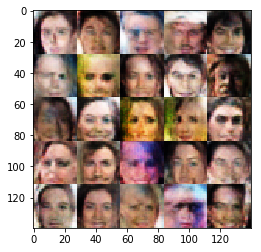

Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 1.2881
Epoch 1/2... Discriminator Loss: 0.9915... Generator Loss: 0.8416
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 1.6856
Epoch 1/2... Discriminator Loss: 1.0564... Generator Loss: 1.4888
Epoch 1/2... Discriminator Loss: 1.1285... Generator Loss: 0.6048
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 1.8580
Epoch 1/2... Discriminator Loss: 0.8244... Generator Loss: 1.1070
Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 0.6267
Epoch 1/2... Discriminator Loss: 1.0202... Generator Loss: 0.6713


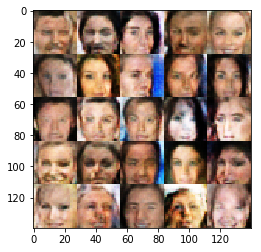

Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 0.6813
Epoch 1/2... Discriminator Loss: 0.8802... Generator Loss: 0.8409
Epoch 1/2... Discriminator Loss: 0.8833... Generator Loss: 1.4348
Epoch 1/2... Discriminator Loss: 0.8565... Generator Loss: 0.9023
Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 1.1558
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 0.5587
Epoch 2/2... Discriminator Loss: 0.9554... Generator Loss: 1.0037
Epoch 2/2... Discriminator Loss: 0.8500... Generator Loss: 1.2180
Epoch 2/2... Discriminator Loss: 0.9340... Generator Loss: 1.8060
Epoch 2/2... Discriminator Loss: 0.7958... Generator Loss: 1.5531


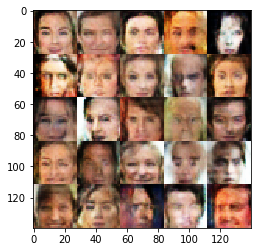

Epoch 2/2... Discriminator Loss: 0.7602... Generator Loss: 1.1542
Epoch 2/2... Discriminator Loss: 0.9914... Generator Loss: 1.5271
Epoch 2/2... Discriminator Loss: 0.9960... Generator Loss: 0.7048
Epoch 2/2... Discriminator Loss: 1.8187... Generator Loss: 2.5485
Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 0.8580
Epoch 2/2... Discriminator Loss: 0.9557... Generator Loss: 0.7960
Epoch 2/2... Discriminator Loss: 1.0492... Generator Loss: 0.8807
Epoch 2/2... Discriminator Loss: 0.7259... Generator Loss: 1.3422
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 1.4400
Epoch 2/2... Discriminator Loss: 1.3156... Generator Loss: 0.4834


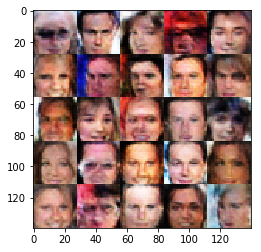

Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.2571
Epoch 2/2... Discriminator Loss: 1.0477... Generator Loss: 1.6304
Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 0.6895
Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 0.8731
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 1.3255
Epoch 2/2... Discriminator Loss: 0.8855... Generator Loss: 0.8801
Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 0.9919
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 1.8780
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 0.9021
Epoch 2/2... Discriminator Loss: 0.9758... Generator Loss: 0.9149


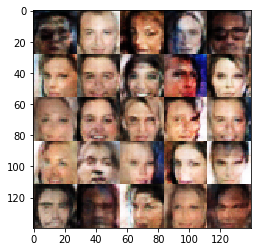

Epoch 2/2... Discriminator Loss: 0.9361... Generator Loss: 0.8656
Epoch 2/2... Discriminator Loss: 0.6776... Generator Loss: 1.6457
Epoch 2/2... Discriminator Loss: 1.0256... Generator Loss: 0.6372
Epoch 2/2... Discriminator Loss: 0.9541... Generator Loss: 0.8094
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 1.4443
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 1.1969
Epoch 2/2... Discriminator Loss: 1.0160... Generator Loss: 0.9741
Epoch 2/2... Discriminator Loss: 0.9280... Generator Loss: 1.5277
Epoch 2/2... Discriminator Loss: 0.9889... Generator Loss: 1.0894
Epoch 2/2... Discriminator Loss: 0.8589... Generator Loss: 1.0872


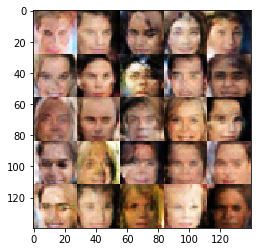

Epoch 2/2... Discriminator Loss: 0.8562... Generator Loss: 1.1459
Epoch 2/2... Discriminator Loss: 1.1258... Generator Loss: 0.6595
Epoch 2/2... Discriminator Loss: 1.4462... Generator Loss: 0.4182
Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 0.9766
Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 0.8459
Epoch 2/2... Discriminator Loss: 1.4997... Generator Loss: 0.3454
Epoch 2/2... Discriminator Loss: 1.0584... Generator Loss: 1.0292
Epoch 2/2... Discriminator Loss: 1.4780... Generator Loss: 0.3902
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 0.7278
Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 1.7170


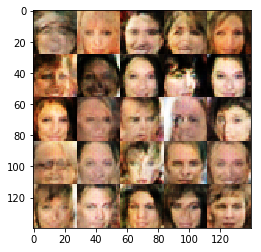

Epoch 2/2... Discriminator Loss: 0.7294... Generator Loss: 1.2364
Epoch 2/2... Discriminator Loss: 1.4923... Generator Loss: 0.3981
Epoch 2/2... Discriminator Loss: 1.0969... Generator Loss: 0.6591
Epoch 2/2... Discriminator Loss: 0.9022... Generator Loss: 1.0334
Epoch 2/2... Discriminator Loss: 0.9805... Generator Loss: 0.7678
Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 0.8350
Epoch 2/2... Discriminator Loss: 0.9700... Generator Loss: 1.2178
Epoch 2/2... Discriminator Loss: 0.8188... Generator Loss: 1.1139
Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 0.7029
Epoch 2/2... Discriminator Loss: 1.0084... Generator Loss: 0.7642


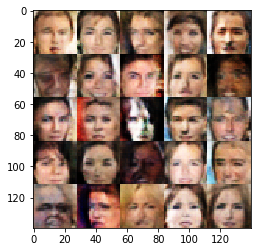

Epoch 2/2... Discriminator Loss: 0.9794... Generator Loss: 0.8529
Epoch 2/2... Discriminator Loss: 1.0900... Generator Loss: 0.9418
Epoch 2/2... Discriminator Loss: 0.8707... Generator Loss: 1.2890
Epoch 2/2... Discriminator Loss: 1.0952... Generator Loss: 1.3102
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 0.4177
Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 0.8699
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 1.9968
Epoch 2/2... Discriminator Loss: 1.2267... Generator Loss: 0.5681
Epoch 2/2... Discriminator Loss: 0.7539... Generator Loss: 1.1559
Epoch 2/2... Discriminator Loss: 0.9195... Generator Loss: 1.1068


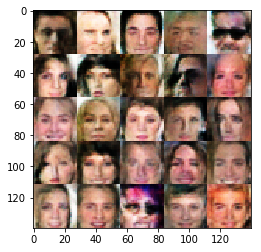

Epoch 2/2... Discriminator Loss: 0.9844... Generator Loss: 1.7162
Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 1.5968
Epoch 2/2... Discriminator Loss: 1.1078... Generator Loss: 0.6727
Epoch 2/2... Discriminator Loss: 1.2393... Generator Loss: 0.4819
Epoch 2/2... Discriminator Loss: 1.0625... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 1.0001... Generator Loss: 1.1212
Epoch 2/2... Discriminator Loss: 0.7516... Generator Loss: 1.4588
Epoch 2/2... Discriminator Loss: 0.8011... Generator Loss: 1.2037
Epoch 2/2... Discriminator Loss: 0.9590... Generator Loss: 1.3211
Epoch 2/2... Discriminator Loss: 0.9725... Generator Loss: 0.8947


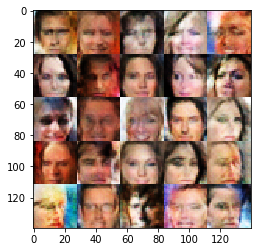

Epoch 2/2... Discriminator Loss: 1.0054... Generator Loss: 1.6919
Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 0.4239
Epoch 2/2... Discriminator Loss: 1.1252... Generator Loss: 0.6504
Epoch 2/2... Discriminator Loss: 1.0121... Generator Loss: 1.3644
Epoch 2/2... Discriminator Loss: 1.1764... Generator Loss: 0.6185
Epoch 2/2... Discriminator Loss: 1.3268... Generator Loss: 0.4654
Epoch 2/2... Discriminator Loss: 1.1929... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 1.6005
Epoch 2/2... Discriminator Loss: 0.9399... Generator Loss: 0.9589
Epoch 2/2... Discriminator Loss: 0.9216... Generator Loss: 1.1445


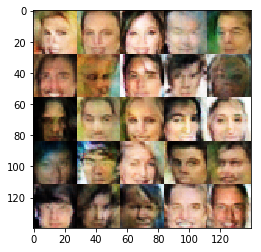

Epoch 2/2... Discriminator Loss: 1.0166... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 1.1054
Epoch 2/2... Discriminator Loss: 0.8482... Generator Loss: 1.2797
Epoch 2/2... Discriminator Loss: 0.8410... Generator Loss: 1.3247
Epoch 2/2... Discriminator Loss: 1.0972... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 1.8285... Generator Loss: 0.2588
Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 1.1032
Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 1.3466
Epoch 2/2... Discriminator Loss: 0.8685... Generator Loss: 1.0533
Epoch 2/2... Discriminator Loss: 0.7969... Generator Loss: 2.0164


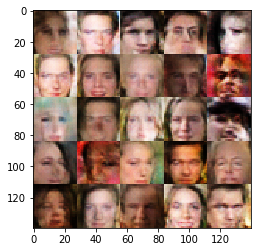

Epoch 2/2... Discriminator Loss: 0.9740... Generator Loss: 1.1717
Epoch 2/2... Discriminator Loss: 1.0269... Generator Loss: 1.0528
Epoch 2/2... Discriminator Loss: 0.8995... Generator Loss: 0.9872
Epoch 2/2... Discriminator Loss: 0.9428... Generator Loss: 1.5934
Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 1.0104
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 1.8824
Epoch 2/2... Discriminator Loss: 0.9848... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 0.9401
Epoch 2/2... Discriminator Loss: 1.1141... Generator Loss: 0.6782
Epoch 2/2... Discriminator Loss: 1.0163... Generator Loss: 0.7361


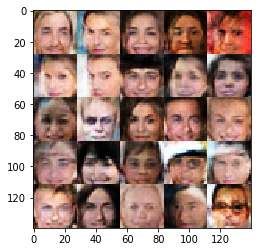

Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 0.8000
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 1.0011
Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 0.6598
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 1.0284... Generator Loss: 0.9395
Epoch 2/2... Discriminator Loss: 1.2845... Generator Loss: 0.5050
Epoch 2/2... Discriminator Loss: 0.7676... Generator Loss: 1.5598
Epoch 2/2... Discriminator Loss: 1.2139... Generator Loss: 0.5530
Epoch 2/2... Discriminator Loss: 1.2530... Generator Loss: 0.4958
Epoch 2/2... Discriminator Loss: 1.5958... Generator Loss: 0.3475


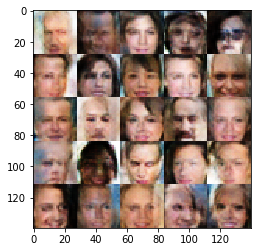

Epoch 2/2... Discriminator Loss: 0.8751... Generator Loss: 1.2557
Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 0.5123
Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 0.4988
Epoch 2/2... Discriminator Loss: 0.8786... Generator Loss: 1.3118
Epoch 2/2... Discriminator Loss: 1.1703... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 0.9467... Generator Loss: 1.2672
Epoch 2/2... Discriminator Loss: 0.8567... Generator Loss: 0.8485
Epoch 2/2... Discriminator Loss: 1.1847... Generator Loss: 2.3693
Epoch 2/2... Discriminator Loss: 1.2243... Generator Loss: 0.5736
Epoch 2/2... Discriminator Loss: 0.8764... Generator Loss: 1.0936


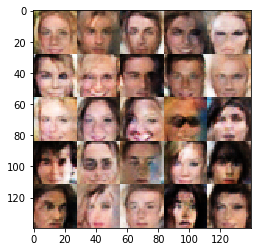

Epoch 2/2... Discriminator Loss: 0.9756... Generator Loss: 1.3525
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 0.8748
Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 1.1115
Epoch 2/2... Discriminator Loss: 1.2615... Generator Loss: 0.4719
Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 0.8180
Epoch 2/2... Discriminator Loss: 1.1623... Generator Loss: 0.6156
Epoch 2/2... Discriminator Loss: 1.1882... Generator Loss: 1.8294
Epoch 2/2... Discriminator Loss: 0.8726... Generator Loss: 0.9487
Epoch 2/2... Discriminator Loss: 1.0774... Generator Loss: 0.8206
Epoch 2/2... Discriminator Loss: 0.9185... Generator Loss: 0.7958


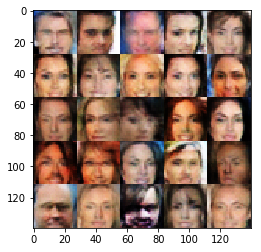

Epoch 2/2... Discriminator Loss: 0.8838... Generator Loss: 1.0933
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 1.9564
Epoch 2/2... Discriminator Loss: 1.3739... Generator Loss: 1.9207
Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 1.4364
Epoch 2/2... Discriminator Loss: 0.8808... Generator Loss: 1.1157
Epoch 2/2... Discriminator Loss: 1.0173... Generator Loss: 0.8390
Epoch 2/2... Discriminator Loss: 1.6870... Generator Loss: 0.2912
Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 0.5099
Epoch 2/2... Discriminator Loss: 1.5325... Generator Loss: 0.3552
Epoch 2/2... Discriminator Loss: 1.6656... Generator Loss: 0.3255


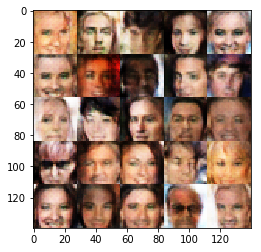

Epoch 2/2... Discriminator Loss: 1.0401... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 1.1165... Generator Loss: 0.6887
Epoch 2/2... Discriminator Loss: 0.8967... Generator Loss: 0.9055
Epoch 2/2... Discriminator Loss: 1.0181... Generator Loss: 0.7260
Epoch 2/2... Discriminator Loss: 0.9517... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 0.8921... Generator Loss: 0.8677
Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 2.1984
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 0.7205
Epoch 2/2... Discriminator Loss: 0.8247... Generator Loss: 1.2616
Epoch 2/2... Discriminator Loss: 1.0517... Generator Loss: 0.6925


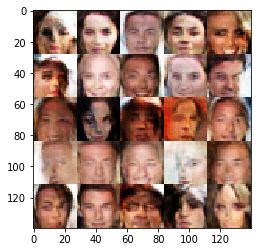

Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.8000
Epoch 2/2... Discriminator Loss: 1.2089... Generator Loss: 0.5663
Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 0.4544
Epoch 2/2... Discriminator Loss: 0.8515... Generator Loss: 0.8845
Epoch 2/2... Discriminator Loss: 1.5541... Generator Loss: 0.3391
Epoch 2/2... Discriminator Loss: 0.9091... Generator Loss: 1.0124
Epoch 2/2... Discriminator Loss: 0.9271... Generator Loss: 1.1190
Epoch 2/2... Discriminator Loss: 0.7301... Generator Loss: 1.5002
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 0.9651
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.4996


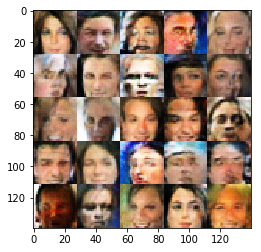

Epoch 2/2... Discriminator Loss: 1.0883... Generator Loss: 0.8821
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 1.3352
Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 0.5535
Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 0.9403... Generator Loss: 0.8404
Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 0.7441
Epoch 2/2... Discriminator Loss: 1.3954... Generator Loss: 0.3845
Epoch 2/2... Discriminator Loss: 2.1940... Generator Loss: 0.1945
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 1.1257
Epoch 2/2... Discriminator Loss: 0.9905... Generator Loss: 1.2095


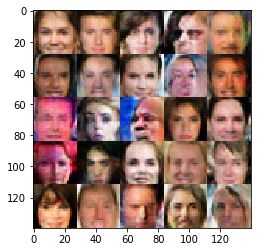

Epoch 2/2... Discriminator Loss: 0.7787... Generator Loss: 1.1018
Epoch 2/2... Discriminator Loss: 1.1360... Generator Loss: 1.7956
Epoch 2/2... Discriminator Loss: 0.9851... Generator Loss: 1.6061
Epoch 2/2... Discriminator Loss: 1.3106... Generator Loss: 1.3505
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 0.7688
Epoch 2/2... Discriminator Loss: 0.8137... Generator Loss: 1.6604
Epoch 2/2... Discriminator Loss: 0.8985... Generator Loss: 1.1034
Epoch 2/2... Discriminator Loss: 0.8887... Generator Loss: 2.0674
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 0.8913
Epoch 2/2... Discriminator Loss: 1.1291... Generator Loss: 1.2954


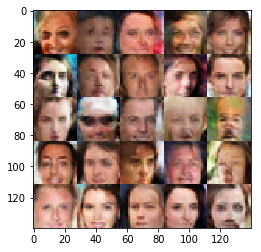

Epoch 2/2... Discriminator Loss: 0.9269... Generator Loss: 0.9307
Epoch 2/2... Discriminator Loss: 0.8952... Generator Loss: 1.7367
Epoch 2/2... Discriminator Loss: 1.0887... Generator Loss: 0.6678
Epoch 2/2... Discriminator Loss: 0.9755... Generator Loss: 0.7218
Epoch 2/2... Discriminator Loss: 0.8181... Generator Loss: 1.3878
Epoch 2/2... Discriminator Loss: 1.1833... Generator Loss: 1.9362
Epoch 2/2... Discriminator Loss: 1.5601... Generator Loss: 0.3210
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 0.7490
Epoch 2/2... Discriminator Loss: 0.9444... Generator Loss: 0.8133
Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 1.4763


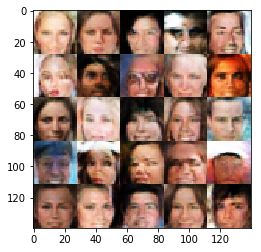

Epoch 2/2... Discriminator Loss: 0.7823... Generator Loss: 1.0060
Epoch 2/2... Discriminator Loss: 1.0236... Generator Loss: 0.9481
Epoch 2/2... Discriminator Loss: 0.9932... Generator Loss: 1.1546
Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 0.7248
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 1.4447
Epoch 2/2... Discriminator Loss: 1.3607... Generator Loss: 0.3940
Epoch 2/2... Discriminator Loss: 1.0105... Generator Loss: 0.8571
Epoch 2/2... Discriminator Loss: 1.0578... Generator Loss: 0.7367
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 1.5372
Epoch 2/2... Discriminator Loss: 1.1143... Generator Loss: 1.2059


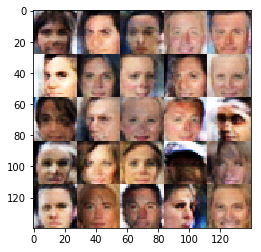

Epoch 2/2... Discriminator Loss: 0.9335... Generator Loss: 0.9258
Epoch 2/2... Discriminator Loss: 1.0710... Generator Loss: 0.5881
Epoch 2/2... Discriminator Loss: 1.1650... Generator Loss: 0.5888
Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 1.8909
Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 1.0766
Epoch 2/2... Discriminator Loss: 1.5645... Generator Loss: 1.2139
Epoch 2/2... Discriminator Loss: 0.9547... Generator Loss: 0.8808
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 1.3081
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 0.7863
Epoch 2/2... Discriminator Loss: 1.0388... Generator Loss: 0.7121


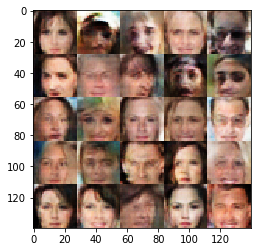

Epoch 2/2... Discriminator Loss: 0.7690... Generator Loss: 1.8098
Epoch 2/2... Discriminator Loss: 0.8055... Generator Loss: 1.3425
Epoch 2/2... Discriminator Loss: 1.3186... Generator Loss: 0.5220
Epoch 2/2... Discriminator Loss: 1.0929... Generator Loss: 1.9118
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 2.3309
Epoch 2/2... Discriminator Loss: 0.9102... Generator Loss: 1.7193
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 0.8696
Epoch 2/2... Discriminator Loss: 1.5643... Generator Loss: 0.4427
Epoch 2/2... Discriminator Loss: 0.9932... Generator Loss: 1.5309
Epoch 2/2... Discriminator Loss: 0.8784... Generator Loss: 0.8961


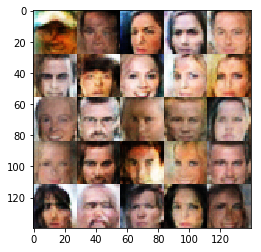

Epoch 2/2... Discriminator Loss: 0.8433... Generator Loss: 0.9850
Epoch 2/2... Discriminator Loss: 1.0274... Generator Loss: 1.6175
Epoch 2/2... Discriminator Loss: 0.8316... Generator Loss: 2.1480
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 0.7239
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.1544
Epoch 2/2... Discriminator Loss: 1.1206... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 0.8932... Generator Loss: 1.0489
Epoch 2/2... Discriminator Loss: 0.8109... Generator Loss: 1.0159
Epoch 2/2... Discriminator Loss: 0.9921... Generator Loss: 0.7077
Epoch 2/2... Discriminator Loss: 0.8531... Generator Loss: 1.2814


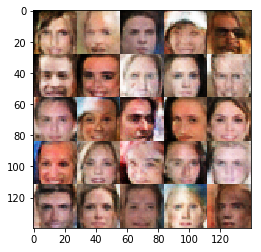

Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 1.4194
Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 0.8608
Epoch 2/2... Discriminator Loss: 0.7637... Generator Loss: 1.6504
Epoch 2/2... Discriminator Loss: 1.0438... Generator Loss: 1.0360
Epoch 2/2... Discriminator Loss: 1.0798... Generator Loss: 1.3173
Epoch 2/2... Discriminator Loss: 0.8770... Generator Loss: 1.4163
Epoch 2/2... Discriminator Loss: 1.2207... Generator Loss: 0.8162
Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.6665
Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 1.1533
Epoch 2/2... Discriminator Loss: 0.9878... Generator Loss: 1.1364


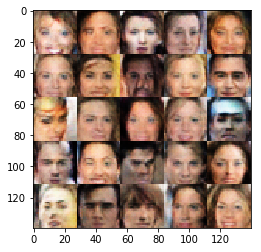

Epoch 2/2... Discriminator Loss: 1.1495... Generator Loss: 2.0229
Epoch 2/2... Discriminator Loss: 0.7973... Generator Loss: 1.0895
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.4103
Epoch 2/2... Discriminator Loss: 1.6780... Generator Loss: 0.2626
Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 1.1823
Epoch 2/2... Discriminator Loss: 0.8641... Generator Loss: 1.0484
Epoch 2/2... Discriminator Loss: 1.4989... Generator Loss: 0.3446
Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 0.5975
Epoch 2/2... Discriminator Loss: 0.8372... Generator Loss: 1.0757
Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 1.2597


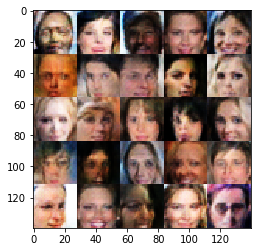

Epoch 2/2... Discriminator Loss: 1.1370... Generator Loss: 0.6083
Epoch 2/2... Discriminator Loss: 1.1838... Generator Loss: 1.5299
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 1.2846
Epoch 2/2... Discriminator Loss: 1.0673... Generator Loss: 1.2394
Epoch 2/2... Discriminator Loss: 1.6615... Generator Loss: 2.5018
Epoch 2/2... Discriminator Loss: 1.2247... Generator Loss: 1.6460
Epoch 2/2... Discriminator Loss: 0.7667... Generator Loss: 1.2234
Epoch 2/2... Discriminator Loss: 0.8795... Generator Loss: 0.8792
Epoch 2/2... Discriminator Loss: 1.2132... Generator Loss: 0.5615
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 0.7987


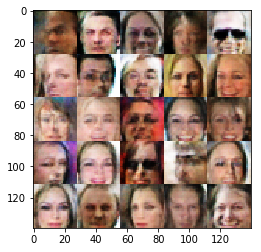

Epoch 2/2... Discriminator Loss: 1.0880... Generator Loss: 2.0940
Epoch 2/2... Discriminator Loss: 0.9972... Generator Loss: 0.9893
Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 0.5426
Epoch 2/2... Discriminator Loss: 0.8834... Generator Loss: 1.8256
Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 0.7805
Epoch 2/2... Discriminator Loss: 0.6537... Generator Loss: 1.3289
Epoch 2/2... Discriminator Loss: 1.1996... Generator Loss: 0.7190
Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 1.4612
Epoch 2/2... Discriminator Loss: 0.9932... Generator Loss: 1.0446
Epoch 2/2... Discriminator Loss: 1.1881... Generator Loss: 0.5216


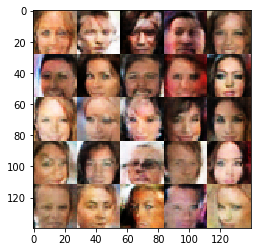

Epoch 2/2... Discriminator Loss: 0.8718... Generator Loss: 1.2204
Epoch 2/2... Discriminator Loss: 0.8539... Generator Loss: 1.1403
Epoch 2/2... Discriminator Loss: 2.0352... Generator Loss: 0.1961
Epoch 2/2... Discriminator Loss: 1.1660... Generator Loss: 0.5544
Epoch 2/2... Discriminator Loss: 0.7620... Generator Loss: 1.9947
Epoch 2/2... Discriminator Loss: 1.1167... Generator Loss: 0.6176
Epoch 2/2... Discriminator Loss: 0.8548... Generator Loss: 0.9276
Epoch 2/2... Discriminator Loss: 1.4279... Generator Loss: 0.4094
Epoch 2/2... Discriminator Loss: 0.8810... Generator Loss: 1.7429
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 0.8677


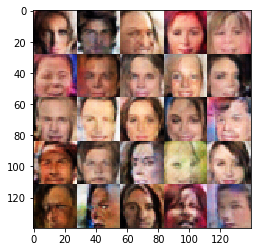

Epoch 2/2... Discriminator Loss: 0.8404... Generator Loss: 1.8055
Epoch 2/2... Discriminator Loss: 1.1865... Generator Loss: 1.7001
Epoch 2/2... Discriminator Loss: 0.6253... Generator Loss: 1.5393
Epoch 2/2... Discriminator Loss: 0.9302... Generator Loss: 1.5092
Epoch 2/2... Discriminator Loss: 0.8750... Generator Loss: 2.1169
Epoch 2/2... Discriminator Loss: 0.5404... Generator Loss: 1.4915
Epoch 2/2... Discriminator Loss: 0.8954... Generator Loss: 0.9341
Epoch 2/2... Discriminator Loss: 0.9825... Generator Loss: 1.2022
Epoch 2/2... Discriminator Loss: 0.9263... Generator Loss: 0.9625
Epoch 2/2... Discriminator Loss: 0.9535... Generator Loss: 0.9133


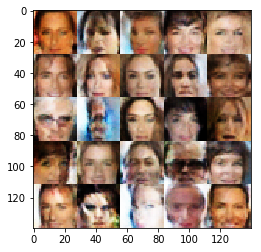

Epoch 2/2... Discriminator Loss: 1.1959... Generator Loss: 0.5854
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 1.3051
Epoch 2/2... Discriminator Loss: 0.8972... Generator Loss: 1.3233
Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 1.2846
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 0.5895
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 1.8468
Epoch 2/2... Discriminator Loss: 0.6964... Generator Loss: 1.2092
Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 2.1714
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 1.0530
Epoch 2/2... Discriminator Loss: 0.7880... Generator Loss: 1.1058


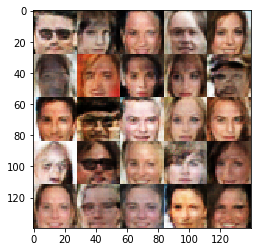

Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 1.0283
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 0.5506
Epoch 2/2... Discriminator Loss: 1.2624... Generator Loss: 0.4805
Epoch 2/2... Discriminator Loss: 1.0648... Generator Loss: 1.7616
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 1.0718
Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 0.8784
Epoch 2/2... Discriminator Loss: 0.9740... Generator Loss: 2.0067
Epoch 2/2... Discriminator Loss: 1.1199... Generator Loss: 0.7387
Epoch 2/2... Discriminator Loss: 0.9490... Generator Loss: 1.0840
Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 1.9927


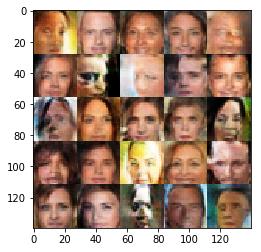

Epoch 2/2... Discriminator Loss: 0.9113... Generator Loss: 1.2068
Epoch 2/2... Discriminator Loss: 0.7219... Generator Loss: 1.1360
Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 0.5494


In [15]:


z_dim = z_dim
beta1 = beta1
batch_size = batch_size
learning_rate = learning_rate




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.